# Problem Set 2

### Cameron Smith

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as op
from matplotlib.ticker import MaxNLocator
from jax import grad
import pymc3 as pm

## Question 1

Define Rosenbrock's Function

In [4]:
def rosenbrocks(x, y):
    return (1 - x)**2 + 100*(y - x**2)**2

Plot contours:

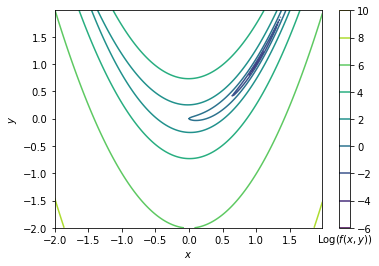

In [5]:
xs = np.arange(-2, 2, 4/250)
ys = np.arange(-2, 2, 4/250)
x, y = np.meshgrid(xs, ys)
z = np.log(rosenbrocks(x, y))
fig, ax = plt.subplots()
cs = ax.contour(x, y, z)
cbar = fig.colorbar(cs)
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")
cbar.ax.set_xlabel(r'Log($f(x, y)$)');

Now we want to find the minima of Rosenbroock's function using a variety of methods, and see the path traversed by each optimisation algorithm.

First we define 

Minimum found using Nelder-Mead is 5.309343918637161e-10, which occurs at [0.99999886 0.99999542].
Minimum found using L-BFGS-B is 9.480664019991428e-12, which occurs at [0.99999692 0.99999383].
Minimum found using TNC is 5.077292054665952e-13, which occurs at [0.99999936 0.9999987 ].


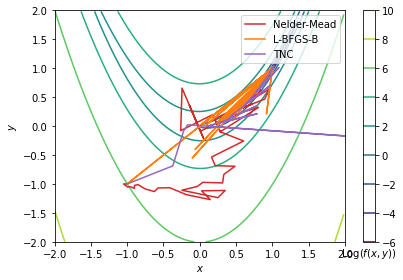

In [6]:
positions = []

def objective_function(theta):
    positions.append(theta)
    return rosenbrocks(*theta)


methods = ['Nelder-Mead', 'L-BFGS-B', 'TNC']
cmap = ['tab:red', 'tab:orange', 'tab:purple']
c = 0
for method in methods:
    positions = []
    
    op_result = op.minimize(
        objective_function,
        [-1, -1],
        method=method)
    minimum = rosenbrocks(*op_result.x)
    print(f"Minimum found using {method} is {minimum}, which occurs at {op_result.x}.")
    positions = np.array(positions).T
    ax.plot(positions[0], positions[1], label=method, c=cmap[c])
    c += 1
ax.legend()
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
fig.tight_layout()
fig

## Question 2

Using the code provided, we generate fake data from the model:
$$
y \sim \mathcal{N}\left(\theta_0 + \theta_1x + \theta_2x^2 + \theta_3x^3,\sigma_{y}\right)
$$

In [7]:
np.random.seed(0)

N = 30

x = np.random.uniform(0, 100, N)

theta = np.random.uniform(-1e-3, 1e-3, size=(4, 1))

# Define the design matrix.
A = np.vstack([
    np.ones(N),
    x, 
    x**2, 
    x**3
]).T
      
y_true = (A @ theta).flatten()
y_err_intrinsic = 10 # MAGIC number!
y_err = y_err_intrinsic * np.random.randn(N)
y = y_true + np.random.randn(N) * y_err
y_err = np.abs(y_err)

First, let's plot the data, and the true model:

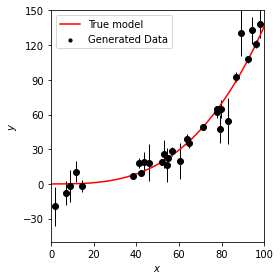

In [8]:
def model(x, theta):
    N = len(x)
    A = np.vstack([
    np.ones(N),
    x, 
    x**2, 
    x**3
    ]).T
    return (A @ theta).flatten()
      
x_true = np.arange(0, 100, 0.1)
y_true = model(x_true, theta)

fig, ax = plt.subplots(figsize=(4, 4))
    
# plot true model.
ax.plot(x_true, y_true, c="r", label="True model")
    
ax.scatter(x, y, c="k", s=10, label="Generated Data")
ax.errorbar(x, y, yerr=y_err, fmt="o", lw=1, c="k")

ax.set_xlim(0, 100)
ax.set_ylim(-50, 150)
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")
    
ax.xaxis.set_major_locator(MaxNLocator(6))
ax.yaxis.set_major_locator(MaxNLocator(7))
ax.legend()
fig.tight_layout()

We introduce the following matrices:
$$
\mathbf{Y} = \left[\begin{array}{c}
            y_{1} \\
            y_{2} \\
            \vdots \\
            y_{30}
\end{array}\right]
\\
\\
\\
\mathbf{A} = \left[\begin{array}{cc}
        1 & x_1 & x_1^2 & x_1^3\\
        1 & x_2 & x_2^2 & x_2^3\\
        1 &\vdots &\vdots &\vdots \\
        1 & x_{30} & x_{30}^2 & x_{30}^3 
\end{array}\right]
\\
\\
\\
\mathbf{C} = \left[\begin{array}{cccc}
        \sigma_{y1}^2 & 0 & \cdots & 0 \\
        0 & \sigma_{y2}^2 & \cdots & 0 \\
        0 & 0 & \ddots & 0 \\
        0 & 0 & \cdots & \sigma_{y30}^2 
\end{array}\right]
\\
\boldsymbol{\theta} = \left[\begin{array}{c}
            \theta_{0} \\
            \theta_{1} \\
            \theta_{2} \\
            \theta_{3} \\
\end{array}\right]
$$

Where $\mathbf{Y}$ are our data points, $\mathbf{A}$ is the design matrix, $\mathbf{C}$ is the covariance matrix, and $\boldsymbol{\theta}$ are our parameters. The model can then be represented as:

$$
\mathbf{Y} = \mathbf{A}\boldsymbol{\theta} \quad .
$$

As our data points are not the true data points this is overconstrained. Therefore, we must weight the data points using the covariance matrix:

$$
\newcommand{\transpose}{^{\scriptscriptstyle \top}}
            \begin{array}{rcl}
            \mathbf{Y} &=& \mathbf{A}\boldsymbol{\theta} \\
            \mathbf{C}^{-1}\mathbf{Y} &=& \mathbf{C}^{-1}\mathbf{A}\boldsymbol{\theta} \\
            \mathbf{A}\transpose\mathbf{C}^{-1}\mathbf{Y} &=& \mathbf{A}\transpose\mathbf{C}^{-1}\mathbf{A}\boldsymbol{\theta} \\
            \left[\mathbf{A}\transpose\mathbf{C}^{-1}\mathbf{Y}\right] &=& \left[\mathbf{A}\transpose\mathbf{C}^{-1}\mathbf{A}\right]\mathbf{}\boldsymbol{\theta}
            \end{array}
$$

And so we find the point estimate of the best fitting model parameters:

$$
\newcommand{\transpose}{^{\scriptscriptstyle \top}}
\boldsymbol{\theta} = \left[\mathbf{A}\transpose\mathbf{C}^{-1}\mathbf{A}\right]^{-1}\left[\mathbf{A}\transpose\mathbf{C}^{-1}\mathbf{Y}\right] \quad .
$$

Implementing this in code, we get the following:

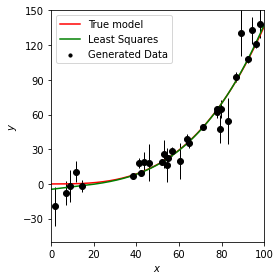

In [9]:
# We have already defined A earlier, and so we get:
Y = np.atleast_2d(y).T

C = np.diag(y_err * y_err)
C_inv = np.linalg.inv(C)

G = np.linalg.inv(A.T @ C_inv @ A)
theta_best_fit = G @ (A.T @ C_inv @ Y)

y_best_fit = model(x_true, theta_best_fit)
ax.plot(x_true, y_best_fit, c='g', label="Least Squares")
ax.legend()
fig.tight_layout()
fig

## Question 3

In [10]:
def neg_log_prob(theta):
    return 0.5 * (theta - 1.2)**2


def H(x, p):
    U = neg_log_prob(x)
    K = p**2/2
    return U + K

positions = []
def leapfrog_integration(x, p, dU_dx, n_steps, step_size):
    """
    Integrate a particle along an orbit using the Leapfrog integration scheme.
    """
    # record initial position
    positions.append((x, p))
    
    x = np.copy(x)
    p = np.copy(p)

    # Take a half-step first.
    p -= 0.5 * step_size * dU_dx(x)
    positions.append((x, p))

    for step in range(n_steps):
        x += step_size * p
        p -= step_size * dU_dx(x)
        positions.append((x, p))

    x += step_size * p
    p -= 0.5 * step_size * dU_dx(x)
    positions.append((x, p))

    return (x, -p)

In [12]:
# Initial guess
x = np.random.uniform(-1., 1.)
p = np.random.normal()

grad_neg_log_prob = grad(neg_log_prob)

# reset positions
positions = []

# integrate
leapfrog_integration(x, p, grad_neg_log_prob, 500, 0.05)
x, p = np.array(positions).T
# energy:
E = H(x, p)

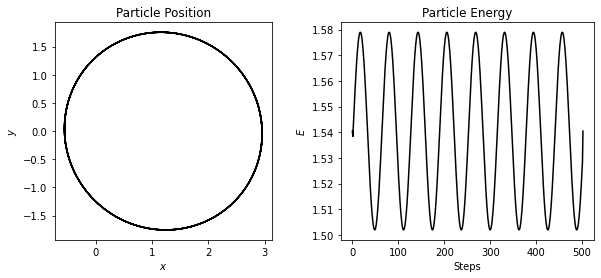

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
# plot position
ax = axs[0]
ax.plot(x, p, c='k')
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")
ax.set_aspect('equal')
ax.set_title("Particle Position")
# plot energy
ax = axs[1]
ax.plot(E, c='k')
ax.set_xlabel("Steps")
ax.set_ylabel(r"$E$")
ax.set_title("Particle Energy");

From the plot energy is clearly not strictly conserved, however is bounded and does not increase or decrease over long periods of time. This effectively means that although the energy fluctuates periodically, the "orbit" does not decay over time.

## Question 4

In [38]:
# redefine grad neg log prob to make it more efficient
def grad_neg_log_prob(theta):
    return theta - 1.2

def hamiltonian_mcmc(x, N):
    # step size
    dx = 0.05
    # no. of steps
    L = 10
    # initial guess
    x0 = x
    chain = []
    for i in range(N):
        print(f"Running step {i} of {N}", end='\r')
        # 1. draw from momentum distribution.
        p0 = np.random.normal()
        # 2. integrate for L steps.
        x1, p1 = leapfrog_integration(x0, p0, grad_neg_log_prob, L, dx)
        # 3. flip sign of momentum.
        p1 = -p1
        # 4. calculate acceptance ratio
        alpha = np.exp(H(x0, p0) - H(x1, p1))
        # 5. accept/reject
        u = np.random.uniform(0., 1.)
        if alpha >= u:
            # accept
            x0 = x1
        chain.append(x0)
    print("\nDone :)")
    return x0, np.array(chain)


In [39]:
x, chain = hamiltonian_mcmc(-10., 2000)

Running step 1999 of 2000
Done :)


In [40]:
# remove burn in:
chain = chain[1000:]

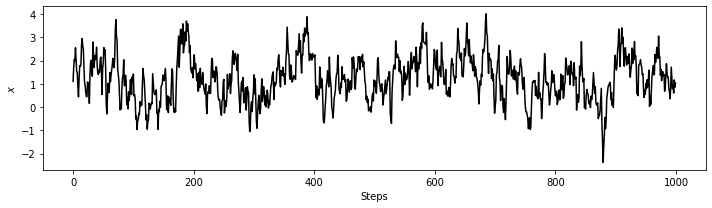

In [41]:
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(chain, c='k')
ax.set_ylabel(r"$x$")
ax.set_xlabel("Steps")
fig.tight_layout()

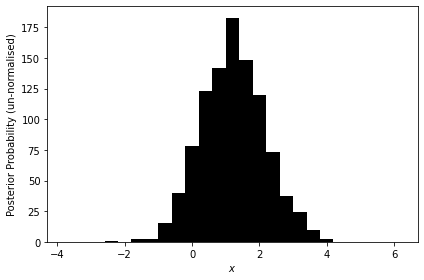

In [42]:
fig, ax = plt.subplots()
ax.hist(chain, 25, (-3.8, 6.2), color='k')
ax.set_xlabel(r"$x$")
ax.set_ylabel("Posterior Probability (un-normalised)")
fig.tight_layout();

## Question 5

In [30]:

# The parallel sampling code in PyMC can
# cause issues for some installations.
cores = 1 
samples = 1000
# our single datapoint
y, y_err = 1.2, 1

with pm.Model() as model:
    # use a broad prior, yt~N(0, 100)

    y_t = pm.Normal('yt', mu=0, sd=100)

    po = pm.Normal(
        'y',
        mu=y_t,
        sd=y_err, 
        observed=y
    )

    start = pm.find_MAP()
    line_trace = pm.sample(
        samples, 
        start=start, 
        cores=cores,
        tune = 1000
    )

/usr/local/lib/python3.7/dist-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -7.163, ||grad|| = 1.2: 100%|██████████| 4/4 [00:00<00:00, 442.66it/s]
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
INFO:pymc3:Sequential sampling (2 chains in 1 job)
NUTS: [yt]
INFO:pymc3:NUTS: [yt]
100%|██████████| 2000/2000 [00:00<00:00, 2274.76it/s]


In [31]:
chain = line_trace.get_values('yt')

In [32]:
# remove burn in
chain = chain[1000:]

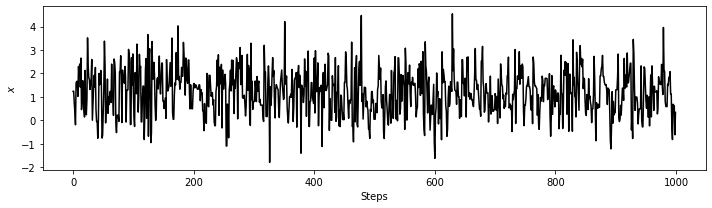

In [33]:
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(chain, c='k', label="True model")
ax.set_ylabel(r"$x$")
ax.set_xlabel("Steps")
fig.tight_layout()

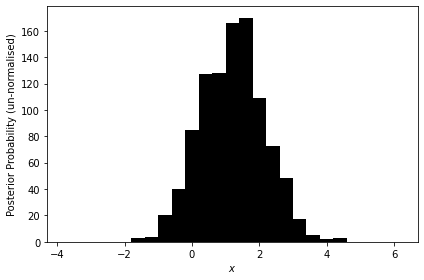

In [36]:
fig, ax = plt.subplots()
ax.hist(chain, 25, (-3.8, 6.2), color='k')
ax.set_xlabel(r"$x$")
ax.set_ylabel("Posterior Probability (un-normalised)")
fig.tight_layout();

Differences:
-- 

## Question 6

First, generate the data again:

In [ ]:
np.random.seed(0)

N = 30

x = np.random.uniform(0, 100, N)

theta = np.random.uniform(-1e-3, 1e-3, size=(4, 1))

# Define the design matrix.
A = np.vstack([
    np.ones(N),
    x, 
    x**2, 
    x**3
]).T
      
y_true = (A @ theta).flatten()
y_err_intrinsic = 10 # MAGIC number!
y_err = y_err_intrinsic * np.random.randn(N)
y = y_true + np.random.randn(N) * y_err
y_err = np.abs(y_err)

In [ ]:
def get_design_matrix(x, N):
    # construct design matrix
    A = np.vstack([
        x**n for n in range(N)
    ]).T
    return A

def poly_model(x, theta):
    # Generate data from points x with parameters theta

    # order
    N = len(theta)
    A = get_design_matrix(x, N)
    return (A @ theta).flatten()

In [ ]:
x_true = np.arange(0, 100, 0.1)
y_true = poly_model(x_true, theta)

fig, ax = plt.subplots(figsize=(4, 4))
    
# plot true model.
ax.plot(x_true, y_true, c="r", label="True model")
    
ax.scatter(x, y, c="k", s=10, label="Generated Data")
ax.errorbar(x, y, yerr=y_err, fmt="o", lw=1, c="k")

ax.set_xlim(0, 100)
ax.set_ylim(-50, 150)
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")
    
ax.xaxis.set_major_locator(MaxNLocator(6))
ax.yaxis.set_major_locator(MaxNLocator(7))
ax.legend()
fig.tight_layout()

In [ ]:
def get_best_parameters(x, y, y_err, N):
    # get best parameters using least squares lin alg solution
    A = get_design_matrix(x, N)
    Y = np.atleast_2d(y).T
    C = np.diag(y_err * y_err)
    C_inv = np.linalg.inv(C)
    G = np.linalg.inv(A.T @ C_inv @ A)
    theta_best_fit = G @ (A.T @ C_inv @ Y)
    return theta_best_fit

# best (least squares) solution for each model:
best_parameters = [get_best_parameters(x, y, y_err, N) for N in range(2, 9)]

for theta in best_parameters:
    N = len(theta)
    y_best_fit = poly_model(x_true, theta)
    ax.plot(x_true, y_best_fit, label=f"Polynomial of degree {N-1}")
    ax.legend()
fig.tight_layout()
fig

In [ ]:
# calculate the inverse variance so we only have to divide once.
y_ivar = 1/(y_err**2)
def ln_likelihood(theta, x, y, y_ivar):
    return -0.5 * np.sum((y - poly_model(x, theta))**2 * y_ivar)

In [ ]:
fig, ax = plt.subplots()
ln_likelihoods = [ln_likelihood(theta, x, y, y_ivar) for theta in best_parameters]
degrees = np.arange(1, 8)
plt.scatter(degrees, ln_likelihoods, c='k')
ax.set_ylabel("Log Likelihood")
ax.set_xlabel("Polonomial degree")
fig.tight_layout;

In [ ]:
def bic(D, N, logL):
    return D*np.log(N) - 2 * logL

bics = [
    bic(i+2, len(y), ln_likelihoods[i])
    for i in range(len(ln_likelihoods))
]

In [ ]:
fig, ax = plt.subplots()
degrees = np.arange(1, 8)
plt.scatter(degrees, bics, c='k')
ax.set_ylabel("BIC")
ax.set_xlabel("Polonomial degree")
fig.tight_layout;

In [ ]:
i = np.argmin(bics)
print(f"The polonomial of degree {i+1} had the lowest BIC, with a value of {bics[i]}.")

Therefore, the model:
$$y \sim \mathcal{N}\left(\theta_0 + \theta_1x + \theta_2x^2 + \theta_3x^3,\sigma_{y}\right)$$
had the lowest BIC. \\
In this case, this matched the actual model used to generate the data.

For a simple model (i.e. not a complex collection of models), if the number of data points $N$ is much larger than the number of parameters $D$ BIC can give an aproximation of the evidence of the model. Furthermore, while the BIC does take into account the number of parameters, it does not consider what kind of parameters are used. For example adding a new parameter that acts as an offset to the data would not change the curvature of the posterior significantly, while a parameter added as an exponent could substantially the curvature of the posterior.

In our case, we are comparing simple models where each parameter is a coefficent of a power of x (i.e. all our parameters have a similar impact on the posterior). Furthermore for 